# Predict Nighttime Light Intensities from Daytime Light 

First pass.  
Current Goal: Use CNN to extract features from daytime lights (Landsat) data and predict levels of nighhtime light intensities (VIIRS).
***
General Steps:
- Import the data
- Feature creation
- Build the Neural Net
- Evaluate the Neural Net

In [45]:
import os
import pandas as pd
import rasterio

import getpass

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [15]:
if getpass.getuser() == 'robmarty':
    project_file_path = '/Users/robmarty/Dropbox/World Bank/IEs/Pakistan Poverty Estimation from Satellites'

# Import the data

In [6]:
#Load single daytime tif file (one observation)
os.chdir("/Users/nguyenluong/wb_internship/Data/satellite_raw")
filepath_day = 'Landsat/2011/stacked/1.tif'
data_day = rasterio.open(filepath_day)
array_day = data_day.read()
print('daytime image shape: {}'.format(array_day.shape))
plt.imshow(data_day.read(1));

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nguyenluong/wb_internship/Data/satellite_raw'

In [3]:
def read_geotiff(filepath):
    '''
    Reads in geotiffs appropriately using rasterio and convert into an array.
    
    Inputs:
        filepath (str)
    Returns:
        (numpy.ndarray) array of arrays where each array represents a band
    '''
    data = rasterio.open(filepath)
    return data.read()


def get_daytime_data(geotiff_source, year, stacked_status):
    '''
    Cycles through all geotiffs in a folder, reads them, adds them to a list.
    
    Inputs:
        directory (str)
    Returns:
        (list) list of arrary where each array represents a geotiff
    '''
    all_data = []
    directory = os.path.join(geotiff_source, year, stacked_status)
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            filepath = os.path.join(directory, filename)
            geotiff_array = read_geotiff(filepath)
            all_data.append(geotiff_array)
    return all_data

In [ ]:
#Define years for daytime data
Landsat_years = ['2013']

#Load in all daytime data
all_daytime_data = []
for year in Landsat_years:
    all_daytime_data.append((year, get_daytime_data('Landsat', year, 'stacked')))

nighttime image shape: (1, 1987, 2519)


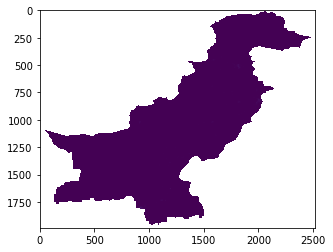

In [4]:
#Load nighttime VIIRS data
filepath_night = 'VIIRS/VIIRS Annual/pak_viirs_median_2018.tif'
data_night = rasterio.open(filepath_night)
array_night = data_night.read()
print('nighttime image shape: {}'.format(array_night.shape))
plt.imshow(data_night.read(1));

In [51]:
filepath_night = project_file_path + "/Data/VIIRS/RawData/VIIRS Annual/pak_viirs_median_2012.tif"

data_night = rasterio.open(filepath_night)

array_night = data_night.read()

np.nanmean(array_night)

(array([1.76688e+06, 3.41840e+04, 7.97700e+03, 3.52100e+03, 1.40200e+03,
        2.42000e+02, 1.70000e+01, 7.00000e+00, 4.00000e+00, 3.00000e+00]),
 array([-0.01496187,  0.73564464,  1.4862511 ,  2.2368577 ,  2.9874642 ,
         3.7380707 ,  4.488677  ,  5.2392836 ,  5.98989   ,  6.7404966 ,
         7.491103  ], dtype=float32),
 <a list of 10 Patch objects>)

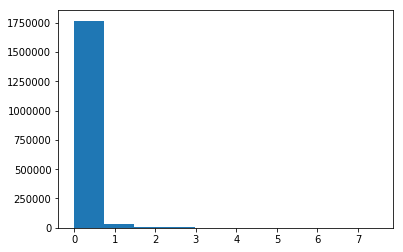

In [70]:
array_night_flat = array_night.flatten()

array_night_flat_nona = array_night_flat[ ~np.isnan(array_night_flat) ]

plt.hist(np.log(array_night_flat_nona+1))



# Feature Creation
Reshape the data into an array of 3D tensors and normalize each element.
***  
*What satellite data ultimately needs to look like*
- data_train, data_test: (np.array) array containing 3D arrays each representing one Landsat image
- target_train, target_test: (np.array with elements in range(0,5)) 1D array of nighttime light intensities split into 5 buckets

In [6]:
#Sample data
from keras.datasets import mnist
(trainX, trainY), (testX, testY) = mnist.load_data()

In [7]:
#Look at array shapes
print('training data shape: {}'.format(trainX.shape))
print('training target shape: {}'.format(trainY.shape))
print('testing data shape: {}'.format(testX.shape))
print('testing target shape: {}'.format(testY.shape))

training data shape: (60000, 28, 28)
training target shape: (60000,)
testing data shape: (10000, 28, 28)
testing target shape: (10000,)


target value: 5


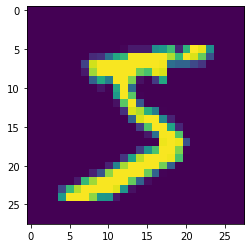

In [8]:
#Sample image and target
plt.imshow(trainX[0], origin='upper', interpolation='nearest');
print('target value: {}'.format(trainY[0]))

In [9]:
def prep_dataset(X, Y, height, width, channels):
    # Reshape dataset to have include a single channel
    X = X.reshape((X.shape[0], height, width, channels))
    # One-hot encode targets
    Y = to_categorical(Y)
    return X, Y

def normalize(X):
    # Convert from ints to floats and normalize to 0-1
    return X.astype('float32') / 255.0

# Build the CNN

In [10]:
def define_model(height, width, channels, num_classes):
    # Define layers
    model = Sequential()
    model.add(Conv2D(filters=64, 
                     kernel_size=(5, 5), 
                     activation='relu', 
                     input_shape=(height, width, channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    print('Model has been defined. Model summary below.')
    model.summary()
    
    return model

# Evaluate the CNN

In [11]:
def evaluate_model(model, trainX, trainY, testX, testY):
    # Fit model
    history = model.fit(trainX, trainY, 
                        epochs=2, batch_size=1000, 
                        validation_data=(testX, testY), verbose=0)
    print('Model has been fit.')
    
    # Evaluate model
    loss, accuracy = model.evaluate(testX, testY, verbose=0)
    print('Model has been evaluted.')
    print('Accuracy: {:.4f}'.format(accuracy))


def evaluate_with_crossval(model, dataX, dataY, k=2):
    # Define k-fold cross-val
    kfold = KFold(k, shuffle=True, random_state=1)
    print('Entering cross validation.')
    
    # Loop through folds
    for train_idx, test_idx in kfold.split(dataX):
        # Select subsets for training and testing
        trainX, trainY, testX, testY = dataX[train_idx], dataY[train_idx], dataX[test_idx], dataY[test_idx]
        print('Subsets have been selected.')
        # Pass to evaluate_model
        evaluate_model(model, trainX, trainY, testX, testY)

In [12]:
def go():
    # Load dataset
    (raw_trainX, raw_trainY), (raw_testX, raw_testY) = mnist.load_data()
    
    # Define image characteristics
    height = raw_trainX[0].shape[0]
    width = raw_trainX[0].shape[1]
    channels = 1
    num_classes = 10 #digits 0-9
    
    # Prep both training and testing data
    trainX, trainY = prep_dataset(raw_trainX, raw_trainY, height, width, channels)
    testX, testY = prep_dataset(raw_testX, raw_testY, height, width, channels)
    
    # Prep pixel data
    trainX, testX = normalize(trainX), normalize(testX)

    # Define and evaluate model
    model = define_model(height, width, channels, num_classes)
    evaluate_model(model, trainX, trainY, testX, testY)
    #evaluate_with_crossval(model, trainX, trainY)

In [13]:
go()

Model has been defined. Model summary below.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               921700    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 924,374
Trainable params: 924,374
Non-trainable params: 0
_________________________________________________________________
Model has been fit.
Model has been evaluted.
Accuracy: 0.9714
